In [111]:
import pickle
import os
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import r2_score, confusion_matrix
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier, EnsembleVoteClassifier


%matplotlib inline

In [112]:
master = pd.read_pickle(os.getcwd() + r'\Data\Intraday\Pickle\master.pkl')

In [113]:
master.head()

,SPX_k1,SPX_k2,SPX_ImpVol1,SPX_ImpVol2,DaysTo_VX1_Expiry,DaysTo_VX2_Expiry,VX1_Future,OPT,VX1-OPT_Spread,VIX_ImpVol,SPX_Index(fwd)
2015-01-02 09:40:00,2070.0,2070.0,0.1326,0.1370,11.9931,32.9931,17.175,13.9409,3.2341,1.1445,2072.15
2015-01-02 09:50:00,2070.0,2070.0,0.1325,0.1362,11.9861,32.9861,17.275,13.8315,3.4435,1.1405,2068.86
2015-01-02 10:00:00,2070.0,2065.0,0.1343,0.1386,11.9792,32.9792,17.375,14.0993,3.2757,1.1428,2068.50
2015-01-02 10:10:00,2065.0,2060.0,0.1397,0.1440,11.9722,32.9722,17.725,14.6378,3.0872,1.1837,2063.32
2015-01-02 10:20:00,2065.0,2060.0,0.1407,0.1449,11.9653,32.9653,17.725,14.7280,2.9970,1.1836,2063.04


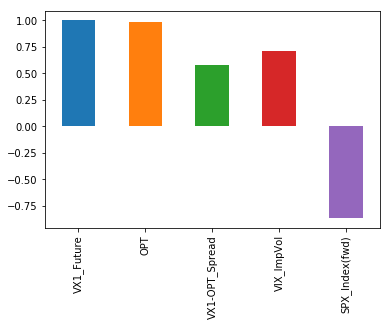

In [114]:
#master.corr().iloc[:,6].plot(kind='bar')
master.iloc[:,6:15].corr().iloc[:,0].plot(kind='bar')

#### Take log returns for every feature EXCEPT $VX1-OPT$ Spread 

In [116]:
master[['Ratio', 'OPT_Ratio','VIX_ImpVol_Ratio', 'SPX_Index(fwd)_Ratio']] = \
        np.log(master[['VX1_Future', 'OPT','VIX_ImpVol', 'SPX_Index(fwd)']]/ \
               master[['VX1_Future', 'OPT','VIX_ImpVol', 'SPX_Index(fwd)']].shift(1))
master.dropna(inplace=True)

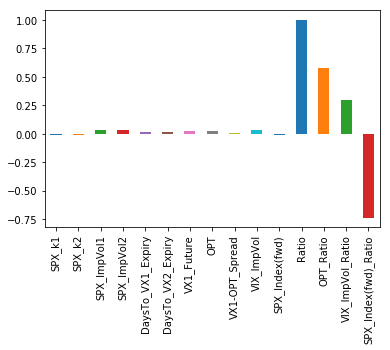

In [117]:
master.corr().loc[:,'Ratio'].plot(kind='bar')

In [118]:
master.shape

(20249, 15)

### Regression

#### Divide dataset into 75/25 (%) Train/Test Split, Scale features for zero mean & unit variance

In [119]:
nTrain = int(.75*master.shape[0])
train, test = master[0:nTrain], master[nTrain:master.shape[0]]

train.is_copy = False
test.is_copy = False

print(train.shape)
print(test.shape)

columns = ['Ratio', 'OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio', 'SPX_Index(fwd)_Ratio']

feature_cols = list(set(columns))

for col in feature_cols:    
    scl = StandardScaler()
    train[col] = scl.fit_transform(train[col].as_matrix().reshape(-1,1))
    test[col] = scl.transform(test[col].as_matrix().reshape(-1,1))

(15186, 15)
(5063, 15)


In [120]:
test.head()

,SPX_k1,SPX_k2,SPX_ImpVol1,SPX_ImpVol2,DaysTo_VX1_Expiry,DaysTo_VX2_Expiry,VX1_Future,OPT,VX1-OPT_Spread,VIX_ImpVol,SPX_Index(fwd),Ratio,OPT_Ratio,VIX_ImpVol_Ratio,SPX_Index(fwd)_Ratio
2016-07-07 13:10:00,2095.0,2090.0,0.1247,0.1332,8.8472,30.8472,16.650,13.6492,0.441010,0.9451,2093.79,0.166924,0.181305,0.328082,-0.013583
2016-07-07 13:20:00,2095.0,2090.0,0.1247,0.1330,8.8403,30.8403,16.575,13.6150,0.382797,0.9552,2094.69,-0.500575,-0.162103,0.462253,0.294499
2016-07-07 13:30:00,2095.0,2095.0,0.1239,0.1301,8.8333,30.8333,16.625,13.2552,0.967492,0.9556,2095.67,0.334364,-1.731500,0.018753,0.320574
2016-07-07 13:40:00,2095.0,2095.0,0.1235,0.1298,8.8264,30.8264,16.525,13.2202,0.874751,0.9449,2096.43,-0.669024,-0.170843,-0.488490,0.248400
2016-07-07 13:50:00,2095.0,2090.0,0.1240,0.1324,8.8194,30.8194,16.575,13.5602,0.460984,0.9519,2094.54,0.335374,1.641889,0.321137,-0.619538


#### Define x, y variables for Train & Test sets

In [121]:
nlags = 10

# CALCULATE TRAINING SET
y_train = train.loc[:,'Ratio'].values[nlags:]
x_train = train.loc[:,['Ratio','OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                              'SPX_Index(fwd)_Ratio']].shift(1).values[nlags:]
for i in range(2,nlags+1):
    lagged_train = train.loc[:,['Ratio', 'OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                           'SPX_Index(fwd)_Ratio']].shift(i).values[nlags:]
    x_train = np.concatenate((x_train, lagged_train), axis=1)

print('x_train: ',x_train.shape)

# CALCULATE TEST SET
y_test = test.loc[:,'Ratio'].values[nlags:]
x_test = test.loc[:,['Ratio','OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                              'SPX_Index(fwd)_Ratio']].shift(1).values[nlags:]
for i in range(2,nlags+1):
    lagged_test = test.loc[:,['Ratio', 'OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                           'SPX_Index(fwd)_Ratio']].shift(i).values[nlags:]
    x_test = np.concatenate((x_test, lagged_test), axis=1)

print('x_test: ',x_test.shape)

x_train:  (15176, 50)
x_test:  (5053, 50)


In [122]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
r1 = lr.score(x_test, y_test)
print(r1)

-0.00927613809245


#### Random Forest

In [128]:
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=5, n_jobs=-1, random_state=1)
rf_reg.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [129]:
r2 = rf_reg.score(x_test,y_test)
print(r2)

0.00447850260808


#### Gradient Boosting

In [126]:
gb_reg = GradientBoostingRegressor(learning_rate=0.05, subsample=0.5, max_depth=3, n_estimators=200)
gb_reg.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False)

In [127]:
r3 = gb_reg.score(x_test,y_test)
print(r3)

0.0237727429274


In [130]:
d = {'Linear Regression': [r1], 'Random Forest': [r2], 'Gradient Boosting': [r3]}
regress = pd.DataFrame(data=d, columns=['Linear Regression', 'Random Forest', 'Gradient Boosting']) 
regress

,Linear Regression,Random Forest,Gradient Boosting
0,-0.009276,0.004479,0.023773


### Quartile Classification

In [131]:
bins = master['Ratio'].quantile(np.arange(0,1.1,.25)).values.tolist()
bins[0] -= 1
bins

[-16.181530948174878,
 -0.3695287618184102,
 0.00023774935829143294,
 0.3580762875300375,
 28.696159238409937]

In [132]:
master['class'] = pd.cut(master['Ratio'], bins=bins, labels=False)

In [133]:
vc = master['class'].value_counts()
print(vc)

1    8140
0    5065
3    5058
2    1986
Name: class, dtype: int64


In [134]:
c1 = round(bins[0]+1,4),round(bins[1],4)
c2 = round(bins[1],4),round(bins[2],4)
c3 = round(bins[2],4),round(bins[3],4)
c4 = round(bins[3],4),round(bins[4],4)
d2 = {c1: [vc[0]], c2: [vc[1]], c3: [vc[2]], c4: [vc[3]]}
#print(c1)
quarts = pd.DataFrame(data=d2, columns=[c1, c2, c3, c4])
quarts

,"(-15.1815, -0.3695)","(-0.3695, 0.0002)","(0.0002, 0.3581)","(0.3581, 28.6962)"
0,5065,8140,1986,5058


#### Divide dataset into 75/25 (%) Train/Test Split, Scale features for zero mean & unit variance

In [135]:
nTrain = int(.75*master.shape[0])
train, test = master[0:nTrain], master[nTrain:master.shape[0]]

train.is_copy = False
test.is_copy = False

print(train.shape)
print(test.shape)

columns = ['Ratio', 'OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio', 'SPX_Index(fwd)_Ratio']

feature_cols = list(set(columns))

for col in feature_cols:    
    scl = StandardScaler()
    train[col] = scl.fit_transform(train[col].as_matrix().reshape(-1,1))
    test[col] = scl.transform(test[col].as_matrix().reshape(-1,1))

(15186, 16)
(5063, 16)


#### Define x, y variables for Train & Test sets

In [136]:
nlags = 10

# CALCULATE TRAINING SET
y_train = train.loc[:,'class'].values[nlags:]
x_train = train.loc[:,['Ratio','OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                              'SPX_Index(fwd)_Ratio']].shift(1).values[nlags:]
for i in range(2,nlags+1):
    lagged_train = train.loc[:,['Ratio', 'OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                           'SPX_Index(fwd)_Ratio']].shift(i).values[nlags:]
    x_train = np.concatenate((x_train, lagged_train), axis=1)

print('x_train: ',x_train.shape)

# CALCULATE TEST SET
y_test = test.loc[:,'class'].values[nlags:]
x_test = test.loc[:,['Ratio','OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                              'SPX_Index(fwd)_Ratio']].shift(1).values[nlags:]
for i in range(2,nlags+1):
    lagged_test = test.loc[:,['Ratio', 'OPT_Ratio', 'VX1-OPT_Spread','VIX_ImpVol_Ratio',\
                           'SPX_Index(fwd)_Ratio']].shift(i).values[nlags:]
    x_test = np.concatenate((x_test, lagged_test), axis=1)

print('x_test: ',x_test.shape)

x_train:  (15176, 50)
x_test:  (5053, 50)


In [137]:
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [138]:
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [139]:
cl1 = KNN.score(x_test, y_test)
print(cl1)

0.40332475757


#### Random Forest

In [140]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1, criterion='entropy', random_state=1)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [141]:
cl2 = rfc.score(x_test,y_test)
print(cl2)

0.446467445082


#### Gradient Boosting Classifier

In [142]:
gbc = GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=3, n_estimators=200)
gbc.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [143]:
cl3 = gbc.score(x_test,y_test)
print(cl3)

0.460716406095


#### Model Stacking ('Wisdom of the Crowd")

In [144]:
# STACK Models
clf1 = KNeighborsClassifier(n_neighbors=7)
clf2 = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=1, criterion='gini', random_state=1)
clf3 = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=1, criterion='entropy', random_state=1)
clf4 = AdaBoostClassifier(n_estimators=200)
clf5 = GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=3, n_estimators=200)
#sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4],
sclf = StackingClassifier(classifiers=[clf2, clf3, clf4, clf5],
                          use_probas=False,
                          average_probas=False,
                          meta_classifier=clf4)

#for clf, label in zip([clf1, clf2, clf3, clf4, clf5, sclf],
for clf, label in zip([clf2, clf3, clf4, clf5, sclf],
                      [#'KNN',
                       'RandomForest_gini',
                       'RandomForest_entropy',
                       'AdaBoostClassifier',
                       'GradientBoostingClassifier',
                       'StackingClassifier']):

    print("Accuracy: %0.2f [%s]" % (clf.fit(x_train, y_train).score(x_test, y_test), label))

Accuracy: 0.45 [RandomForest_gini]
Accuracy: 0.45 [RandomForest_entropy]
Accuracy: 0.45 [AdaBoostClassifier]
Accuracy: 0.46 [GradientBoostingClassifier]
Accuracy: 0.46 [StackingClassifier]


In [145]:
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], weights=[1, 1, 1, 2], voting='soft')
eclf.fit(x_train, y_train).score(x_test, y_test)

0.44765485849990105

In [146]:
sclf = StackingClassifier(classifiers=[clf2, clf3, clf4, clf5],
                          use_probas=False,
                          average_probas=False,
                          meta_classifier=clf4)
cl4 = sclf.fit(x_train, y_train).score(x_test, y_test)
print(cl4)

0.460914308332


In [147]:
eclf = EnsembleVoteClassifier(clfs=[clf2, clf3, clf4, clf5], weights=[1, 1, 1, 2], voting='soft')
eclf.fit(x_train, y_train).score(x_test, y_test)

0.45477933900653078

In [148]:
d3 = {'KNeighbors (KNN)': [cl1], 'Random Forest': [cl2], 'Gradient Boosting': [cl3], 'Stacking Classifier': [cl4]}
classify = pd.DataFrame(data=d3, columns=['KNeighbors (KNN)', 'Random Forest', 'Gradient Boosting', 'Stacking Classifier']) 
classify

,KNeighbors (KNN),Random Forest,Gradient Boosting,Stacking Classifier
0,0.403325,0.446467,0.460716,0.460914
